In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from sklearn.datasets import make_blobs

theta = 0.4
c=0.1

K = 10
thetas= np.random.rand(100)*0.4

In [ ]:
#from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.datasets.cifar10 import load_data
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
(x_train,y_train),(x_test,y_test)=load_data()
pca=PCA(26)
scaler = MinMaxScaler()
scaler1=MinMaxScaler((-1,1))

index_0=[i for i in range(len(y_train)) if y_train[i]==0]
index_1=[i for i in range(len(y_train)) if y_train[i]==1]

X0=x_train[index_0]
X1=x_train[index_1]

Y0=y_train[index_0]
Y1=y_train[index_1]


y=np.concatenate((Y0,Y1),axis=0)
X=np.concatenate((X0,X1),axis=0)

X=X.reshape(len(X),X.shape[1]*X.shape[1]*3)
X=scaler.fit_transform(X)
X=pca.fit_transform(X)
T = 100

shuffl=np.random.randint(0,len(X),T+2)

X=X[shuffl]
y=y[shuffl]


X=scaler1.fit_transform(X)

$h: x \rightarrow w^T*x$

In [ ]:
class predicteur():

  def __init__(self,theta,c,dimension):
    self.w = np.random.randn(dimension)
    self.w /= np.linalg.norm(self.w)
    self.theta = np.random.choice(thetas)
    self.voisinage = []
    self.c=c
  def abstain(self,x):
    return abs(np.dot(self.w,x)) - self.theta <= 0

  def predict(self,x):
    return int( np.dot(self.w,x)>0 )
    
  def loss(self,x,y):
    return (1-int(self.abstain(x)))*abs(self.predict(x)-y) + int(self.abstain(x))*self.c

  def plot(self,X,y):
    z = np.array([-self.w[1],self.w[0]])
    x1 = np.arange(-4,4,0.01)*z[0]
    x2 = np.arange(-4,4,0.01)*z[1]

    plt.scatter(X[:,0],X[:,1], c = y)
    plt.plot(x1,x2)
    plt.plot(x1-theta,x2+theta)
    plt.plot(x1+theta,x2-theta)

    plt.show()

In [ ]:
def UCB(predicteurs,X,Y):
  mu = np.zeros((K))
  S = np.zeros((K))
  Q = np.ones((K))
  regrets = []
  predicteurs_choisis = []
  taux_abstention=[]
  for t in range(2,T+2):

    x = X[t-2]
    y = Y[t-2]
    I_t = np.argmin(mu-S)
    predicteurs_I = predicteurs[I_t]

    for i,predicteur in enumerate(predicteurs):
      Q[i]+=1
      mu[i] = predicteur.loss(x,y)/Q[i] + (1-1/Q[i])*mu[i]
      S[i] = np.sqrt(5*np.log(t)/Q[i])
    
    predicteurs_choisis.append(I_t)
    taux_abstention.append(np.mean([predicteur.abstain(x) for predicteur in predicteurs]))
    #if t%2==0:
    S1 = sum([predicteurs[predicteurs_choisis[s]].loss(X[s+2],Y[s+2]) for s in range(t-2)])
    les_S2 = [sum([predicteur.loss(X[s],Y[s]) for s in range(t)]) for predicteur in predicteurs]
    regrets.append(max([(S1 - S2) for S2 in les_S2]))
  return regrets,taux_abstention


In [ ]:
def maj_graph(x,predicteurs):
  edges = set([])
  predit = [i for i in range(K) if not predicteurs[i].abstain(x)]
  for j in predit:
      edges=edges.union(set([(j,i) for i in range(K)]))
  for i in range(K):
    edges=edges.union(set([(i,j) for j in range(K) if j not in predit]))

  G=nx.DiGraph()
  G.add_nodes_from(list(np.arange(K)))
  G.add_edges_from(list(edges))
  return G

In [ ]:
def UCB_GT(predicteurs,X,Y):
  mu = np.zeros((K))
  S = np.zeros((K))
  Q = np.ones((K))
  regrets = []
  predicteurs_choisis = []
  taux_abstention = []
  n_arretes=[len(predicteurs)]*T
  for t in range(2,T+2):

    x = X[t-2]
    y = Y[t-2]
    I_t = np.argmin(mu-S)
    predicteurs_I = predicteurs[I_t]

  
    for i,predicteur in enumerate(predicteurs):
      p_i = 1/(t-1)*sum([predicteurs_I.abstain(X[s])*(1 - predicteur.abstain(X[s])) for s in range(t-1)])
      gamma_i = np.sqrt(5*Q[i]*np.log(t))/((K-1)*(t-1))
      if p_i<=gamma_i : 
        Q[i]+=1
        if predicteurs_I.abstain(x)*(1 - predicteur.abstain(x)):
          mu[i] = (1-1/Q[i])*mu[i]
        else :
          mu[i] = predicteur.loss(x,y)/Q[i] + (1-1/Q[i])*mu[i]
          n_arretes[t-2]+=1
      S[i] = np.sqrt(5*np.log(t)/Q[i])
    
    taux_abstention.append(np.mean([predicteur.abstain(x) for predicteur in predicteurs]))
    predicteurs_choisis.append(I_t)
   # if t%2==0:
    S1 = sum([predicteurs[predicteurs_choisis[s]].loss(X[s+2],Y[s+2]) for s in range(t-2)])
    les_S2 = [sum([predicteur.loss(X[s],Y[s]) for s in range(t)]) for predicteur in predicteurs]
    regrets.append(max([(S1 - S2) for S2 in les_S2]))
      
  return regrets, taux_abstention, n_arretes


In [ ]:
def UCB_NT(predicteurs,X,Y):
  mu = np.zeros((K))
  S = np.zeros((K))
  Q = np.ones((K))
  N_t = []
  predicteurs_choisis = []
  regrets = []
  taux_abstention=[]
  for t in range(T):

    x = X[t]
    y = Y[t]
    I_t = np.argmin(mu-S)
    predicteurs_choisis.append(I_t)
    predicteurs_I = predicteurs[I_t]
    taux_abstention.append(np.mean([predicteur.abstain(x) for predicteur in predicteurs]))
    N_t.append(list(maj_graph(x,predicteurs).neighbors(I_t)))

    #if t%2==0:
    S1 = sum([predicteurs[predicteurs_choisis[s]].loss(X[s],Y[s]) for s in range(t)])
    les_S2 = [sum([predicteur.loss(X[s],Y[s]) for s in range(t)]) for predicteur in predicteurs]
    regrets.append(max([(S1 - S2) for S2 in les_S2]))

    for j,predicteur in enumerate(predicteurs):
      Q[j] = sum([1 if j in N_s else 0 for N_s in N_t])
      S[j] = np.sqrt(5*np.log(t+1)/Q[j])
      mu[j] = 1/Q[j]*sum([predicteur.loss(X[s],Y[s]) if j in N_s else 0 for s,N_s in enumerate(N_t)])



  return regrets, taux_abstention


In [ ]:
def uniform_choice(predicteurs,X,Y):
  predicteurs_choisis = []
  regrets = []
  taux_abstention=[]
  for t in range(T):

    x = X[t]
    y = Y[t]
    I_t = np.random.randint(0,len(predicteurs))
    predicteurs_choisis.append(I_t)
    predicteurs_I = predicteurs[I_t]
    taux_abstention.append(np.mean([predicteur.abstain(x) for predicteur in predicteurs]))

    #if t%2==0:
    S1 = sum([predicteurs[predicteurs_choisis[s]].loss(X[s],Y[s]) for s in range(t)])
    les_S2 = [sum([predicteur.loss(X[s],Y[s]) for s in range(t)]) for predicteur in predicteurs]
    regrets.append(max([(S1 - S2) for S2 in les_S2]))

  return regrets,taux_abstention

In [ ]:
from tqdm import tqdm
K=50
c=0.1
R_nt=[]
R_gt=[]
R_un=[]
R_ucb=[]
abs_nt=[]
abs_gt=[]
abs_un=[]
abs_ucb=[]
N_aretes=[]
for i in tqdm(range(5)):
  predicteurs = [predicteur(theta,c,X.shape[1]) for i in range(K)]
  r_nt,nt_abstention= UCB_NT(predicteurs,X,y)
  r_gt,gt_abstention,n_aretes= UCB_GT(predicteurs,X,y)
  r_ucb,ucb_abstention=UCB(predicteurs,X,y)
  r_un,un_abstention=uniform_choice(predicteurs,X,y)
  R_gt.append(r_gt)
  N_aretes.append(n_aretes)
  R_nt.append(r_nt)
  R_ucb.append(r_ucb)
  R_un.append(r_un)
  abs_gt.append(gt_abstention)
  abs_nt.append(nt_abstention)
  abs_ucb.append(ucb_abstention)
  abs_un.append(un_abstention)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


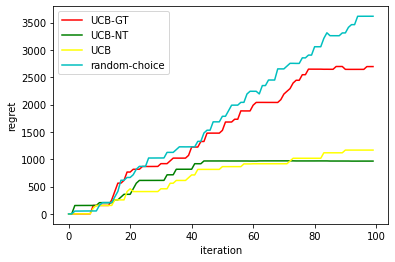

In [ ]:
plt.plot(np.array(R_gt).mean(axis=0),color='red',label='UCB-GT')
plt.plot(np.array(R_nt).mean(axis=0),color='green',label='UCB-NT')
plt.plot(np.array(R_ucb).mean(axis=0),color='yellow',label='UCB')
plt.plot(np.array(R_un).mean(axis=0),color='c',label='random-choice')
plt.xlabel('iteration')
plt.ylabel('regret')
#plt.savefig('regret3.png')
plt.legend()
plt.show()

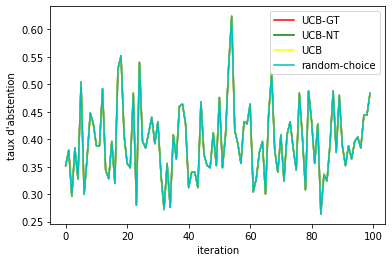

In [ ]:
plt.plot(np.array(abs_gt).mean(axis=0),color='red',label='UCB-GT')
plt.plot(np.array(abs_nt).mean(axis=0),color='green',label='UCB-NT')
plt.plot(np.array(abs_ucb).mean(axis=0),color='yellow',label='UCB')
plt.plot(np.array(abs_un).mean(axis=0),color='c',label='random-choice')
plt.xlabel('iteration')
plt.ylabel('taux d\'abstention')
plt.legend()
plt.show()

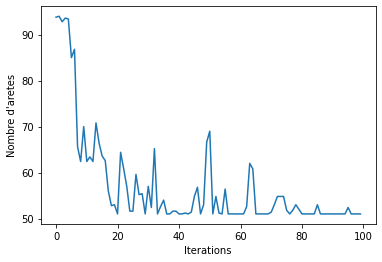

In [ ]:
plt.plot(np.array(N_aretes).mean(axis=0))
plt.xlabel('Iterations')
plt.ylabel('Nombre d\'aretes')
plt.savefig('Nb_aretes.png')
plt.show()

#Exemple de biais

##fonctions en dimension 1

In [ ]:
#On redéfini le prédicteur pour l'adapter en une dimension
class predicteur():

  def __init__(self,theta,cout_abstention=0.1):
    self.w = np.random.randn(1)
    self.w /= np.linalg.norm(self.w)
    self.theta = theta
    self.voisinage = []
    self.cout_abstention = cout_abstention

  def abstain(self,x):
    return abs(self.w-x) - self.theta <= 0

  def predict(self,x):
    return int( self.w-x<0 )

  def loss(self,x,y):
    return (1-int(self.abstain(x)))*abs(self.predict(x)-y) + int(self.abstain(x))*self.cout_abstention

## Biais

In [ ]:
K=2     #deux prédicteurs
T=50   #100 itérations
c=0.2   #coût d'abstention

eps1 = predicteur(0.25)
eps1.w = 0.75
eps2 = predicteur(0.0)
eps2.w = 0.5
predicteurs = [eps1,eps2]

In [ ]:
def plot_fig(c=[0.1,0.99]):
  if type(c)==float:
    c = [c]
  for cout_abstention in c : 
    #on met à jour le cout d'abstention de chaque prédicteur
    for predicteur in predicteurs:
      predicteur.cout_abstention=cout_abstention

    n = 100
    r_unif, t_unif = [],[]
    r_UCB, t_UCB = [], []
    r_NT, t_NT, n_GT = [], []
    r_GT, t_GT, n_GT = [], [], []
    for _ in range(n):
        X1 = np.random.uniform(0,.5,T//5)
        X2 = np.random.uniform(0,1,T-len(X1)+2)
        X = np.concatenate((X1,X2))
        np.random.shuffle(X)

        y = (X>.5)
        regret, taux_abstention = uniform_choice(predicteurs,X,y)
        r_unif.append(regret)
        t_unif.append(taux_abstention)

        regret, taux_abstention = UCB(predicteurs,X,y)
        r_UCB.append(regret)
        t_UCB.append(taux_abstention)

        regret, taux_abstention, n_arretes = UCB_NT(predicteurs,X,y)
        r_NT.append(regret)
        t_NT.append(taux_abstention)
        n_GT.append(n_arretes)

        regret, taux_abstention, n_arretes = UCB_GT(predicteurs,X,y)
        r_GT.append(regret)
        t_GT.append(taux_abstention)
        n_GT.append(n_arretes)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))

    ax1.errorbar(range(25),np.array(r_unif).mean(axis=0),np.array(r_unif).std(axis=0), label = 'random choice')
    ax1.errorbar(range(25),np.array(r_UCB).mean(axis=0),np.array(r_UCB).std(axis=0), label = 'UCB')
    ax1.errorbar(range(25),np.array(r_NT).mean(axis=0),np.array(r_NT).std(axis=0), label = 'UCB-NT')
    ax1.errorbar(range(25),np.array(r_GT).mean(axis=0),np.array(r_GT).std(axis=0),  label = 'UCB-GT')
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("regret")
    ax1.set_title('Regret pour c = {}'.format(cout_abstention))
    ax1.legend()


    ax2.plot(range(50),np.array(t_unif).mean(axis=0), label = 'random choice')
    ax2.plot(range(50),np.array(t_UCB).mean(axis=0), label = 'UCB')
    ax2.plot(range(50),np.array(t_NT).mean(axis=0), label = 'UCB-NT')
    ax2.plot(range(50),np.array(t_GT).mean(axis=0), label = 'UCB-GT')
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("taux d'abstention")
    ax2.set_title("Fraction d'abstention pour c = {}".format(cout_abstention))
    ax2.legend()


    ax3.plot(np.array(n_GT).mean(axis=0),color='red')
    ax3.set_xlabel("Iterations")
    ax3.set_ylabel("Nombre de liaisons")
    ax3.set_title("Nombre de liaisons pour c = {}".format(cout_abstention))
    fig.show()

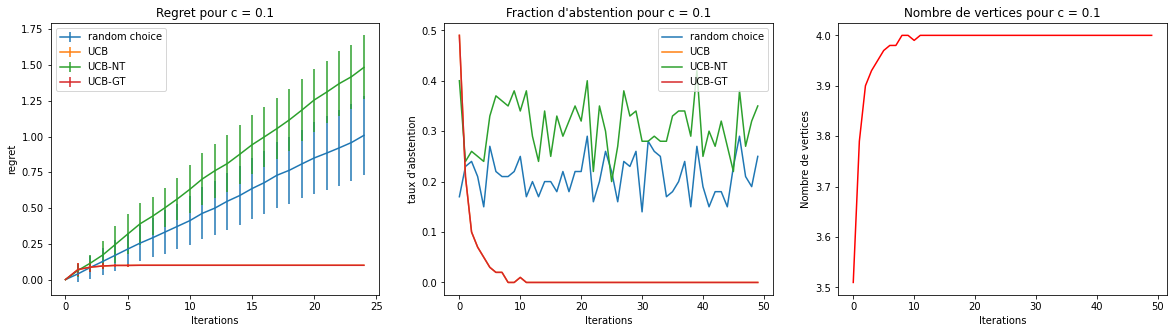

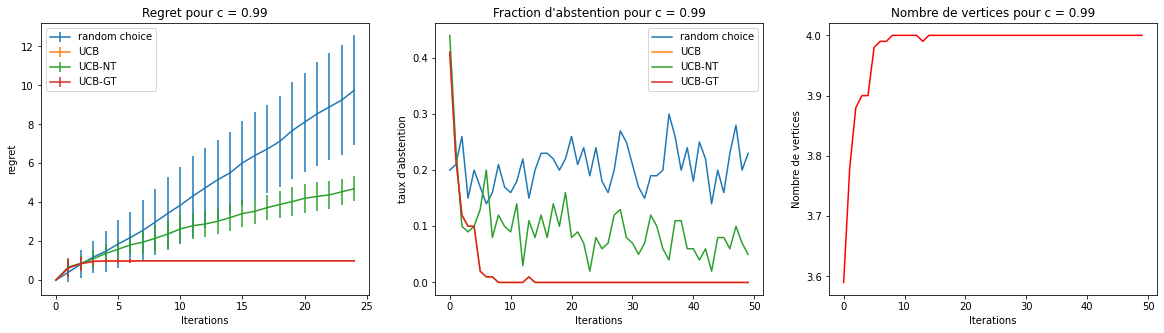

In [ ]:
plot_fig()